# Modelling
<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* Ridge and Lasso Regularization (add on to linear modelling?)

<u> Tests using the following variables:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables:
    * Sensor_id
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   


Normalise variables: should this be with MinMax or StandardScaler??


Process:
* Keep only data from sensor's with relatively complete data
* Split data into training ( 75%) and test (25%)
* Define the models to use in testing (linear regression, random forest, xgboost)
* Define the error metrics to use in evaluating the model performance

In [44]:
import copy
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, mean_squared_error,r2_score, accuracy_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
import time as thetime
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier, XGBRegressor
from time import time
from sklearn.inspection import permutation_importance
from scipy import stats
import math

from eli5.sklearn import PermutationImportance
from sklearn.model_selection import cross_val_predict

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import multiprocessing

# To display tables in HTML output
from IPython.display import HTML, display

from Functions import *

## Read in formatted data

In [48]:
data = pd.read_csv("../Cleaned_data/formatted_data_for_modelling_allsensors.csv", index_col = False)

### Delete unneeded columns
We currently include data from all sensors (even incomplete ones)

In [3]:
data = data.drop(['sensor_id'],axis=1) # don't want this included
# Get rid of columns in which none of the sensors have a value
for column in data.columns:
    if np.nanmax(data[column]) ==0:
        del data[column]

In [4]:
# Filter columns using the regex pattern in function input
regex_pattern = 'buildings$|furniture$|landmarks$'
data = data[data.columns.drop(list(data.filter(regex=regex_pattern)))].copy()

### Add a random variable (to compare performance of other variables against)

In [5]:
rng = np.random.RandomState(seed=42)
data['random'] = np.random.random(size=len(data))
data["random_cat"] = rng.randint(3, size=data.shape[0])

In [6]:
# print(len(data['random'].unique()))
# print(len(data))

## Prepare data for modelling 
### Split into predictor/predictand variables

In [7]:
# The predictor variables
Xfull = data.drop(['hourly_counts'], axis =1)
# The variable to be predicted
Yfull = data['hourly_counts'].values

### Store the (non Sin/Cos) time columns and then remove them
Need them later to segment the results by hour of the day

In [8]:
data_time_columns = Xfull[['day_of_month_num', 'time', 'weekday_num', 'time_of_day']]
Xfull = Xfull.drop(['day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num'],axis=1)

Random Forest was the best performing model

## Fit the final model
For this, we use all of the data

In [39]:
# 1
rf_model_pipeline2 = Pipeline(steps=[['scaler',StandardScaler()],
                                    ['rf_regressor',RandomForestRegressor(random_state = 1, n_jobs = 32)]])
rf_model_pipeline2.fit(Xfull[:10], Yfull[:10])
# 2
# rf_model_pipeline2 = Pipeline(steps=[['scaler',StandardScaler()],
#                                     ['rf_regressor',RandomForestRegressor(n_estimators = 500, random_state = 2, n_jobs = 32)]])
# rf_model_pipeline2.fit(Xfull, Yfull);
# # 3
# rf_model_pipeline3 = Pipeline(steps=[['scaler',StandardScaler()],
#                                     ['rf_regressor',RandomForestRegressor(n_estimators = 500, random_state = 3, n_jobs = 32)]])
# rf_model_pipeline3.fit(Xfull, Yfull);

['rf_model_pipeline2.sav']

### Find Gini impurity feature importances
Gini feature importance (or mean decrease in impurity) counts the number of times a feature is used to split a node, weighted by the number of samples it splits.

In [41]:
def find_gini_importance(model):
    # Get numerical feature importances
    rf_importances = list(model.feature_importances_)
    rf_feature_importances = pd.DataFrame({'feature': Xfull.columns,'importance':rf_importances})      
    rf_feature_importances= rf_feature_importances.sort_values(by = 'importance', ascending = True)
    # Get just the features that scored more highly than a random feature
    rf_feature_importances_overrandom = rf_feature_importances[rf_feature_importances['importance']>rf_feature_importances.query("feature=='random'")["importance"].values[0]]
    return rf_feature_importances
    
gi_1 = find_gini_importance(loaded_model['rf_regressor'])    
# gi_2 = find_gini_importance(rf_model_pipeline2['rf_regressor'])   
# gi_3 = find_gini_importance(rf_model_pipeline3['rf_regressor'])   

### Find the permutation importances

In [13]:
# This is based on analysis of how the score changes when the feature is not available
# Thus we need to chose the accuracy score to use
def find_permutation_importance(model, Xfull, Yfull, n_iter):
    # instantiate permuter object
    permuter = PermutationImportance(model, scoring='neg_mean_absolute_error', cv='prefit', n_iter=n_iter)
    permuter.fit(Xfull.values, Yfull)
    # Create a dataframe containing the mean results (and std)
    pi_meanvalues_df = pd.DataFrame({'feature':Xfull.columns,
                  'importance':permuter.feature_importances_,
                  'Feature_importance_std': permuter.feature_importances_std_}).sort_values('importance', ascending = True)
    # Get the raw results for each permutation, and store as a dataframe
    pi_raw_results = permuter.results_  
    raw_importances = pd.DataFrame({'feature_list':list(Xfull.columns)})
    for num,results in enumerate(permuter.results_):
        raw_importances[num] = results
    raw_importances =raw_importances.sort_values(by=0, ascending=False)
    raw_importances.reset_index(drop = True, inplace=True)
    
    # Get just the features that scored more highly than a random feature
    return pi_meanvalues_df, raw_importances

pi_1, pi_1_raw = find_permutation_importance(rf_model_pipeline1['rf_regressor'], Xfull, Yfull, n_iter=3)    
# pi_2 = find_permutation_importance(rf_model_pipeline2['rf_regressor'], Xfull, Yfull)   
# pi_3 = find_permutation_importance(rf_model_pipeline3['rf_regressor'], Xfull, Yfull)   

### Plot and compare feature importances

In [ ]:
# cardinality_df = pd.DataFrame({'feature':Xfull.columns, 'n_features':Xfull.nunique()})
# cardinality_df = cardinality_df.merge(pi_1, on='feature', how='outer')
# cardinality_df = cardinality_df.drop([0,1,2,4, 45])
# plt.scatter(cardinality_df['n_features'], cardinality_df['importance'])
# # plt.scatter(cardinality_df[:-2]['n_features'], cardinality_df[:-2]['importance'])
# # cardinality_df

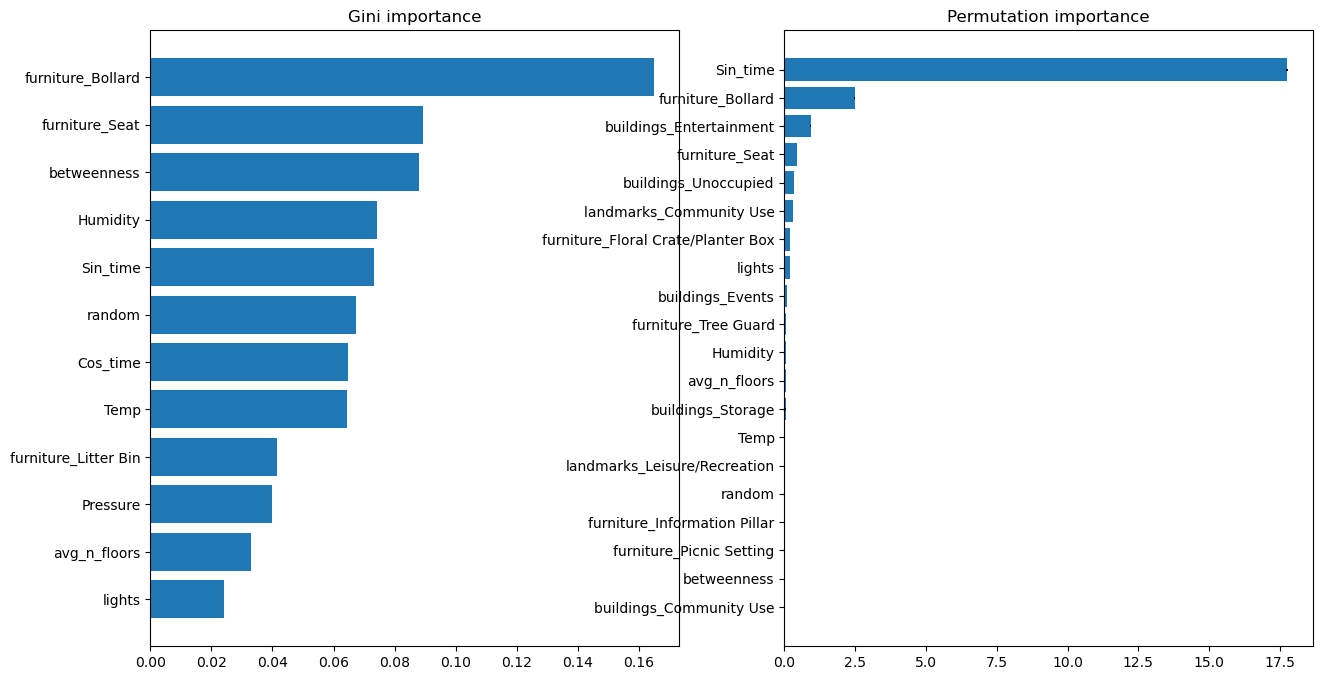

In [14]:
def plot_compare_importances(gini_importances, perm_importances, above_random_cat = False):
    
    if above_random_cat == 'random_num':
        gini_importances = gini_importances[gini_importances['importance']>gini_importances.query("feature=='random'")["importance"].values[0]]
        perm_importances = perm_importances[perm_importances['importance']>perm_importances.query("feature=='random'")["importance"].values[0]]
    elif above_random_cat == 'random_cat':
        gini_importances = gini_importances[gini_importances['importance']>gini_importances.query("feature=='random_cat'")["importance"].values[0]]
        perm_importances = perm_importances[perm_importances['importance']>perm_importances.query("feature=='random_cat'")["importance"].values[0]]
        
    fig, axs = plt.subplots(ncols = 2, figsize=(15,8))
    axs[0].barh(range(len(gini_importances['importance'])), gini_importances["importance"])
    axs[0].set_yticks(range(len(gini_importances["feature"])))
    _ = axs[0].set_yticklabels(np.array(gini_importances["feature"]))
    axs[0].set_title('Gini importance')

    axs[1].barh(range(len(perm_importances['importance'])),
             perm_importances['importance'],
             xerr=perm_importances['Feature_importance_std'])
    axs[1].set_yticks(range(len(perm_importances['importance'])))
    _ = axs[1].set_yticklabels(perm_importances['feature'])  
    axs[1].set_title('Permutation importance')
    
plot_compare_importances(gi_1, pi_1, above_random_cat='random_cat')    

### Plots!?

In [ ]:
# fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize = (15,5))

# axs[0].barh(rf_feature_importances['feature'][:10], rf_feature_importances['importance'][:10])
# axs[0].invert_yaxis()
# plt.rcParams.update({'font.size': 5})
# axs[0].set_title("Feature Importance", fontsize=15, y=1.01)
# axs[0].set_xlabel('Importance', fontsize = 12)
# axs[0].set_ylabel('Feature', fontsize = 12)
# axs[0].xaxis.set_tick_params(labelsize='xx-large')
# axs[0].yaxis.set_tick_params(labelsize='xx-large')

# using_datashader(axs[1],Yfull, rf_predictions, 'linear')
# axs[1].plot([Y_test.min(), Yfull.max()], [Yfull.min(), Y_test.max()], c='k', lw=0.5)
# axs[1].set_ylabel("Predicted Values", size=10)
# axs[1].set_xlabel("Actual Values", size=10)
# axs[1].xaxis.set_tick_params(labelsize='xx-large')
# axs[1].yaxis.set_tick_params(labelsize='xx-large')
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000])

# using_datashader(axs[2], Y_test, rf_predictions, 'log')
# axs[2].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=0.5)
# axs[2].set_ylabel("Predicted Values", size=10)
# axs[2].set_xlabel("Actual Values", size=10)
# axs[2].xaxis.set_tick_params(labelsize='xx-large')
# axs[2].yaxis.set_tick_params(labelsize='xx-large')
# axs[2].set_xlim([0, 2000])
# axs[2].set_ylim([0, 2000])

# plt.show()